Import trick

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

# the real world
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astrocut import fits_cut
from astropy.nddata import Cutout2D

import pandas as pd

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

data

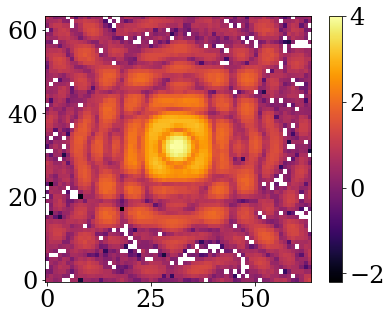

In [3]:
ddir = '../data/MAST_2024-07-11T09_26_05.575Z/'
fname_095 = ddir + 'HST/N43CA5020/n43ca5020_mos.fits'
fname_108 = ddir + 'HST/N43C03020/n43c03020_mos.fits'
fname_187 = ddir + 'HST/N43C03010/n43c03010_mos.fits'
fname_190 = ddir + 'HST/N43CA5010/n43ca5010_mos.fits'


wid = 64

exposure_095 = exposure_from_file(fname_095, SinglePointFit(), wid)
exposure_108 = exposure_from_file(fname_108, SinglePointFit(), wid)
exposure_187 = exposure_from_file(fname_187, SinglePointFit(), wid)
exposure_190 = exposure_from_file(fname_190, SinglePointFit(), wid)

exposures_s = [exposure_095]#, exposure_190]#,exposure_108, exposure_187]

exposure_095 = exposure_from_file(fname_095, BinaryFit(), wid)
exposure_108 = exposure_from_file(fname_108, BinaryFit(), wid)
exposure_187 = exposure_from_file(fname_187, BinaryFit(), wid)
exposure_190 = exposure_from_file(fname_190, BinaryFit(), wid)

exposures_b = [exposure_095]#, exposure_190]#, exposure_108, exposure_187]

snr = exposure_190.data/exposure_190.err
plt.imshow(np.log10(snr))
plt.colorbar()

(array([  1.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   2.,
          2.,   2.,   2.,   0.,   1.,   3.,   5.,   3.,   2.,   4.,   1.,
          5.,   5.,   6.,   6.,  10.,  14.,  19.,  10.,  21.,  28.,  29.,
         42.,  38.,  52.,  52.,  76.,  92., 108., 126., 129., 142., 147.,
        153., 156., 151., 182., 167., 162., 169., 141., 137., 133., 116.,
        114.,  86.,  64.,  98.,  89.,  68.,  65.,  52.,  39.,  51.,  23.,
         18.,  20.,  19.,  11.,  14.,  17.,  13.,   7.,  10.,  13.,  13.,
          7.,  21.,  13.,  13.,  17.,  19.,  17.,  11.,   3.,   1.,   2.,
          3.,   0.,   2.,   4.,   0.,   2.,   5.,   1.,   2.,   1.,   5.,
          2.]),
 array([-3.32650443, -3.26294699, -3.19938955, -3.13583211, -3.07227466,
        -3.00871722, -2.94515978, -2.88160234, -2.81804489, -2.75448745,
        -2.69093001, -2.62737257, -2.56381512, -2.50025768, -2.43670024,
        -2.3731428 , -2.30958535, -2.24602791, -2.18247047, -2.11891303,
        -2.05535558, -1.99

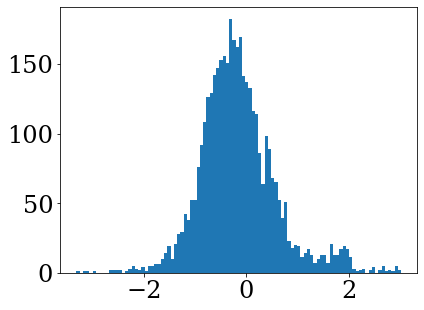

In [4]:
exp = exposure_190

err_test = np.where(exp.bad, 1, np.asarray(exp.err, dtype=float))
data_test = np.where(exp.bad, 1, np.asarray(exp.data, dtype=float))
plt.hist(np.log10(data_test.flatten()), bins=100)

models

In [5]:
oversample = 8

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

params_s = {
    "fluxes": {},
    "positions": {},
    "aberrations": {},#np.zeros(8),#np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "cold_mask_shift": {}, #np.asarray([-0.05, -0.05]),
    "cold_mask_rot": {},#np.asarray([np.pi/4]),
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
}

params_b = {
    "fluxes": {},
    "positions": {},
    "contrast": {},
    "separation": dlu.arcsec2rad(0.042),
    "position_angle": 1.8607855,
    "aberrations": {},#np.zeros(8),#np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "cold_mask_shift": {}, #np.asarray([0.05, 0.05]),
    "cold_mask_rot": {},#np.asarray([np.pi/4]),
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
}

for exp in exposures_s:
    params_s["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params_s["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.nansum(exp.data)
    params_s["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(8)
    params_s["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([-0.05,-0.05])
    params_s["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = np.pi/4

for exp in exposures_b:
    params_b["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params_b["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.nansum(exp.data)/2
    params_b["contrast"][exp.fit.get_key(exp, "contrast")] = 0.3
    params_b["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(8)
    params_b["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([-0.05,-0.05])
    params_b["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = np.pi/4

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

point_model = set_array(NICMOSModel(exposures_s, params_s, optics, detector))
binary_model = set_array(NICMOSModel(exposures_b, params_b, optics, detector))
params_s = ModelParams(params_s)
params_b = ModelParams(params_b)

In [6]:

def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]

g = 3e-2

things_single = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*1, 0),
    "cold_mask_shift": opt(g*100, 100),
    "cold_mask_rot": opt(g*100, 100),
    "aberrations": opt(g*0.12,50),
    "outer_radius": opt(g*200, 130),
    "secondary_radius": opt(g*100,130),
    "spider_width": opt(g*200,130),
}

g = 2e-2

things_binary = {
    "fluxes" : opt(g*10,10),
    "positions": opt(g*1, 0),
    "separation": opt(g*5, 20),
    "contrast": opt(g*8, 20),
    "position_angle": opt(g*1, 20),
    "cold_mask_shift": opt(g*100,130),
    "cold_mask_rot": opt(g*100,100),
    "aberrations": opt(g*1,50),
    "outer_radius": opt(g*50, 100),
    "secondary_radius": opt(g*50,100),
    "spider_width": opt(g*10,100),
}

groups_s = list(things_single.keys())
paths_s = flatten(groups_s)
optimisers_s = [things_single[i] for i in groups_s]
groups_s = [list(x) if isinstance(x, tuple) else x for x in groups_s]

groups_b = list(things_binary.keys())
paths_b = flatten(groups_b)
optimisers_b = [things_binary[i] for i in groups_b]
groups_b = [list(x) if isinstance(x, tuple) else x for x in groups_b]

In [7]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths_s)
def loss_fn_s(params,exposures):
    model = params.inject(point_model)
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))

@zdx.filter_jit
@zdx.filter_value_and_grad(paths_b)
def loss_fn_b(params,exposures):
    model = params.inject(binary_model)
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))

In [8]:
point_model

NICMOSModel(
  params={
    'aberrations':
    {'N43CA5020': f64[8]},
    'cold_mask_rot':
    {'N43CA5020': f64[]},
    'cold_mask_shift':
    {'N43CA5020': f64[2]},
    'fluxes':
    {'N43CA5020': f64[]},
    'outer_radius':
    f64[],
    'positions':
    {'N43CA5020': f64[2]},
    'secondary_radius':
    f64[],
    'spider_width':
    f64[]
  },
  filters={'F095N': f64[28,2]},
  optics=NICMOSOptics(
    wf_npixels=512,
    diameter=f64[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=None,
        apertures={
          'cold_mask':
          NICMOSColdMask(
            normalise=True,
            transformation=CoordTransform(
              translation=f64[2],
              rotation=f64[],
              compression=None,
              shear=None
            ),
            apertures={
              'outer':
              CircularAperture(
                normalise=False,
                transformation=None,
            

In [9]:
print(loss_fn_s(params_s, exposures_s))
print(loss_fn_b(params_b, exposures_b))

(Array(39760166.14646605, dtype=float64), ModelParams(
  params={
    'aberrations':
    {'N43CA5020': f64[8]},
    'cold_mask_rot':
    {'N43CA5020': f64[]},
    'cold_mask_shift':
    {'N43CA5020': f64[2]},
    'fluxes':
    {'N43CA5020': f64[]},
    'outer_radius':
    f64[],
    'positions':
    {'N43CA5020': f64[2]},
    'secondary_radius':
    f64[],
    'spider_width':
    f64[]
  }
))
(Array(19437591.06232889, dtype=float64), ModelParams(
  params={
    'aberrations':
    {'N43CA5020': f64[8]},
    'cold_mask_rot':
    {'N43CA5020': f64[]},
    'cold_mask_shift':
    {'N43CA5020': f64[2]},
    'contrast':
    {'N43CA5020': f64[]},
    'fluxes':
    {'N43CA5020': f64[]},
    'outer_radius':
    f64[],
    'position_angle':
    f64[],
    'positions':
    {'N43CA5020': f64[2]},
    'secondary_radius':
    f64[],
    'separation':
    f64[],
    'spider_width':
    f64[]
  }
))


In [10]:
rc = False
fishers_s = calc_fishers(point_model, exposures_s, paths_s, recalculate=rc)
lrs_s = calc_lrs(point_model, exposures_s, fishers_s, paths_s)

fishers_b = calc_fishers(binary_model, exposures_b, paths_b, recalculate=rc)
lrs_b = calc_lrs(binary_model, exposures_b, fishers_b, paths_b)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[30.45376268]]
[[ 3.92011230e+21 -1.42886596e+20]
 [-1.42886596e+20  4.24458313e+21]]
[[-8.36162407e+11  6.29656756e+11]
 [ 6.29656756e+11 -8.12883129e+11]]
[[-8.51875936e+11]]
[[-2.02959107e+21  1.72061151e+20  5.29781432e+20  1.04233225e+21
   7.37617217e+20 -9.67543246e+19 -2.09877291e+20 -1.64499894e+20]
 [ 1.72061151e+20 -3.40104694e+21 -2.04158161e+20  8.88761642e+20
   5.97933469e+20  5.33851941e+20 -5.24951182e+20  1.53309023e+20]
 [ 5.29781432e+20 -2.04158161e+20 -3.44954773e+21 -1.20096949e+21
   5.07732415e+20  4.88011194e+20  3.99051316e+20  1.25554439e+20]
 [ 1.04233225e+21  8.88761642e+20 -1.20096949e+21 -3.43786558e+20
  -2.38720268e+20  5.96546645e+20  2.83599798e+20  7.04624985e+20]
 [ 7.37617217e+20  5.97933469e+20  5.07732415e+20 -2.38720268e+20
   1.48534817e+20 -2.02673053e+20 -3.47075402e+20  5.11764657e+20]
 [-9.67543246e+19  5.33851941e+20  4.88011194e+20  5.96546645e+20
  -2.02673053e+20  2.52561046e+20 -2.47121706e+20 -5.92149072e+19]
 [-2.09877291e+20 -5.249

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[[30.45376268]]
[[ 3.92011230e+21 -1.42886596e+20]
 [-1.42886596e+20  4.24458313e+21]]
[[8.82396441e+20]]
[[67626178.59603669]]
[[21600529.81027301]]
[[-8.36162407e+11  6.29656756e+11]
 [ 6.29656756e+11 -8.12883129e+11]]
[[-8.51875936e+11]]
[[-2.02959107e+21  1.72061151e+20  5.29781432e+20  1.04233225e+21
   7.37617217e+20 -9.67543246e+19 -2.09877291e+20 -1.64499894e+20]
 [ 1.72061151e+20 -3.40104694e+21 -2.04158161e+20  8.88761642e+20
   5.97933469e+20  5.33851941e+20 -5.24951182e+20  1.53309023e+20]
 [ 5.29781432e+20 -2.04158161e+20 -3.44954773e+21 -1.20096949e+21
   5.07732415e+20  4.88011194e+20  3.99051316e+20  1.25554439e+20]
 [ 1.04233225e+21  8.88761642e+20 -1.20096949e+21 -3.43786558e+20
  -2.38720268e+20  5.96546645e+20  2.83599798e+20  7.04624985e+20]
 [ 7.37617217e+20  5.97933469e+20  5.07732415e+20 -2.38720268e+20
   1.48534817e+20 -2.02673053e+20 -3.47075402e+20  5.11764657e+20]
 [-9.67543246e+19  5.33851941e+20  4.88011194e+20  5.96546645e+20
  -2.02673053e+20  2.5256104

In [11]:
optim_s, opt_state_s = zdx.get_optimiser(
    params_s, groups_s, optimisers_s
)


losses_s, models_s = [], []
for i in tqdm(range(300)):
    loss, grads = loss_fn_s(params_s,exposures_s)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs_s.params))
    updates, opt_state_s = optim_s.update(grads, opt_state_s)
    params_s = zdx.apply_updates(params_s, updates)

    models_s.append(params_s)
    losses_s.append(loss)

optim_b, opt_state_b = zdx.get_optimiser(
    params_b, groups_b, optimisers_b
)


losses_b, models_b = [], []
for i in tqdm(range(300)):
    loss, grads = loss_fn_b(params_b,exposures_b)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs_b.params))
    updates, opt_state_b = optim_b.update(grads, opt_state_b)
    params_b = zdx.apply_updates(params_b, updates)

    models_b.append(params_b)
    losses_b.append(loss)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [12]:
print(losses_s[0], losses_s[-1])
print(losses_b[0], losses_b[-1])


39760166.146466054 940891.581995666
19437591.06232889 636201.8331272474


In [13]:
for g in groups_s:
    if type(g) == list:
        for s in g:
            print(s, point_model.get(s))
    else:
        print(g, point_model.get(g))

print()

for g in groups_b:
    if type(g) == list:
        for s in g:
            print(s, binary_model.get(s))
    else:
        print(g, binary_model.get(g))

fluxes {'N43CA5020': Array(6308.58288966, dtype=float64)}
positions {'N43CA5020': Array([0., 0.], dtype=float64)}
cold_mask_shift {'N43CA5020': Array([-0.05, -0.05], dtype=float64)}
cold_mask_rot {'N43CA5020': Array(0.78539816, dtype=float64)}
aberrations {'N43CA5020': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)}
outer_radius 1.146
secondary_radius 0.44639999999999996
spider_width 0.0924

fluxes {'N43CA5020': Array(3154.29144483, dtype=float64)}
positions {'N43CA5020': Array([0., 0.], dtype=float64)}
separation 2.0362174606600512e-07
contrast {'N43CA5020': Array(0.3, dtype=float64)}
position_angle 1.8607855
cold_mask_shift {'N43CA5020': Array([-0.05, -0.05], dtype=float64)}
cold_mask_rot {'N43CA5020': Array(0.78539816, dtype=float64)}
aberrations {'N43CA5020': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)}
outer_radius 1.146
secondary_radius 0.44639999999999996
spider_width 0.0924


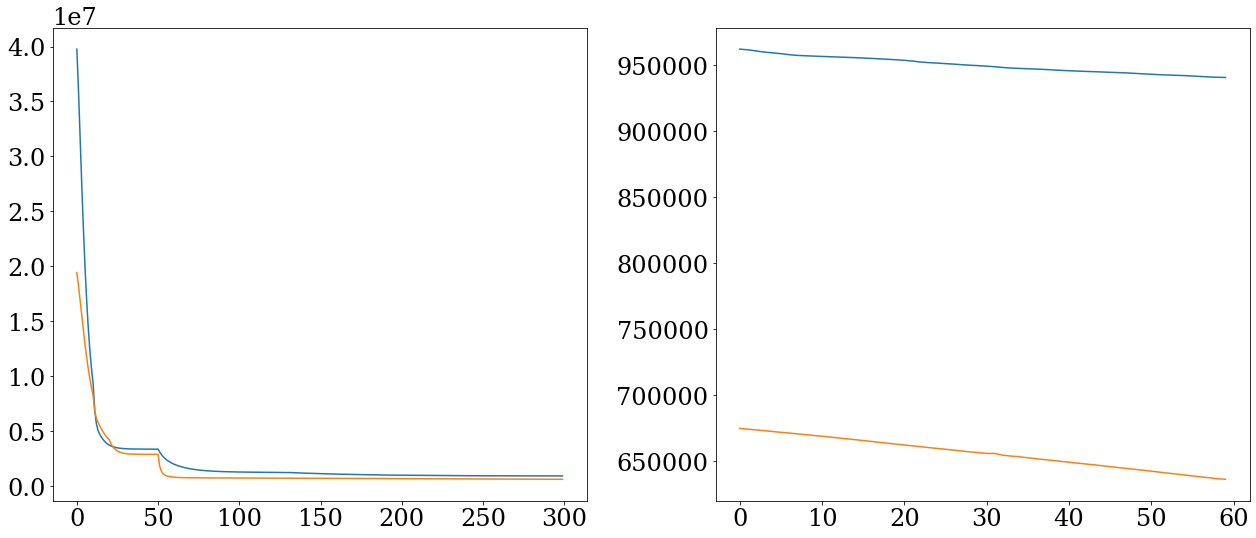

In [14]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
axs[0].plot(losses_s)
axs[1].plot(losses_s[-60:])
axs[0].plot(losses_b)
axs[1].plot(losses_b[-60:])
fig.tight_layout()

32.42778647676577 32.109411527293155


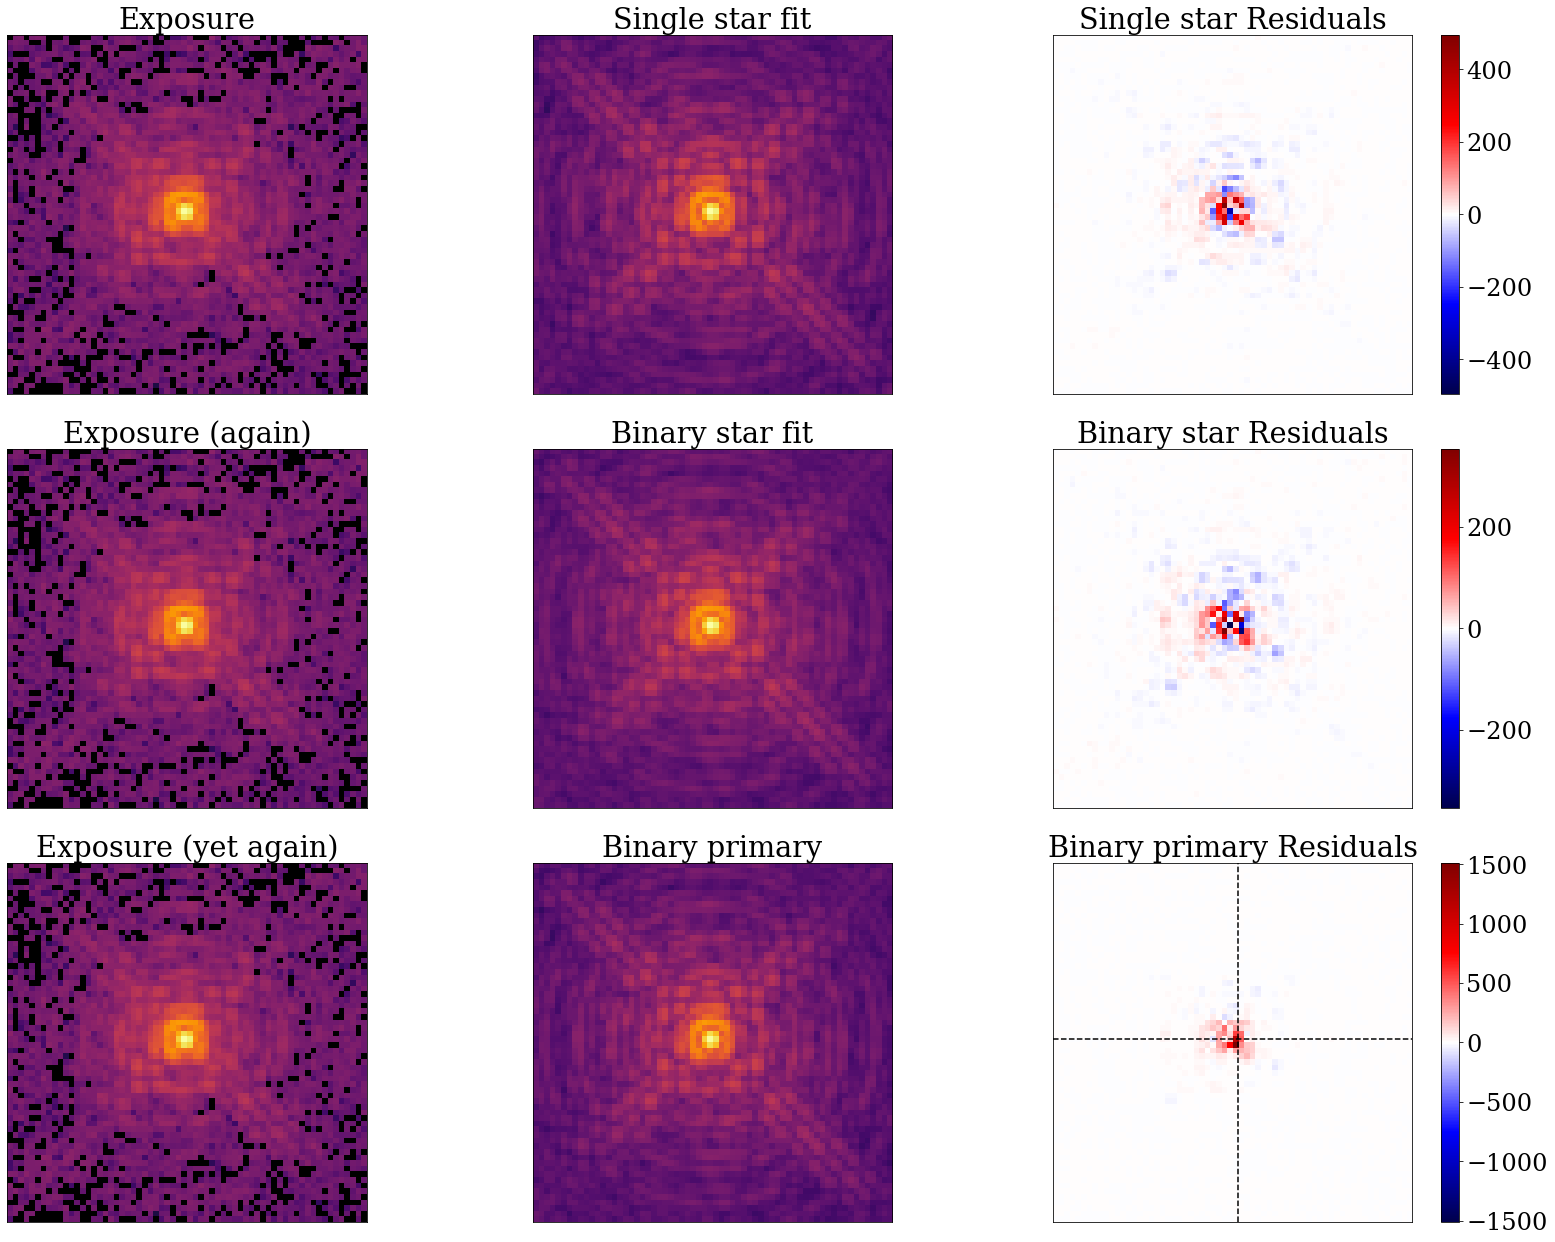

In [15]:
fig, axs = plt.subplots(3,3,figsize=(30*0.8,22*0.8))

point_model = params_s.inject(point_model)
binary_model = params_b.inject(binary_model)

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

ind = 0

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exposures_s[ind].data**0.125

exposure_s = exposures_s[ind]
exposure_b = exposures_b[ind]

point_frame = exposure_s.fit(point_model, exposure_s)**0.125
binary_frame = exposure_b.fit(binary_model, exposure_b)**0.125

single_resid = (exposure_s.data-exposure_s.fit(point_model, exposure_s))/exposure_s.err
binary_resid = (exposure_b.data-exposure_b.fit(binary_model, exposure_b))/exposure_b.err

vm = max(np.nanmax(cropped_frame),np.nanmax(point_frame), np.nanmax(binary_frame))


axs[0,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[0,1].imshow(point_frame,cmap=cmap, vmin=0, vmax=vm)
rlim = np.nanmax(np.abs(single_resid))
resid = axs[0,2].imshow(single_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[0,2])

axs[1,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[1,1].imshow(binary_frame,cmap=cmap, vmin=0, vmax=vm)

rlim = np.nanmax(np.abs(binary_resid))
resid = axs[1,2].imshow(binary_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[1,2])

#f095n = np.asarray(pd.read_csv("../data/HST_NICMOS1.F095N.dat", sep=' '))

e_filter = binary_model.filters[exposure_b.filter]

wavels = e_filter[:,0]
weights = e_filter[:,1]

positions = dlu.positions_from_sep(
        binary_model.get(exposure_b.map_param("positions")),
        binary_model.params["separation"],
        binary_model.params["position_angle"]
    )

binary_primary_source = dl.PointSource(
    spectrum=dl.Spectrum(wavels,weights),
    position = positions[1],
    flux = dlu.fluxes_from_contrast(
        binary_model.get(exposure_b.map_param("fluxes")),
        binary_model.get(exposure_b.map_param("contrast")),
    )[1]
)

binary_optics = exp.fit.update_optics(binary_model, exp)


binary_primary_system = dl.Telescope(
    binary_optics,
    #binary_model.optics,
    binary_primary_source,
    binary_model.detector
)

binary_primary_frame = binary_primary_system.model()**0.125

axs[2,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[2,1].imshow(binary_primary_frame,cmap=cmap, vmin=0, vmax=vm)

bp_resid = (exposure_b.data-binary_primary_system.model())/exposure_b.err
rlim = np.nanmax(np.abs(bp_resid))
resid = axs[2,2].imshow(bp_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[2,2])

x, y = dlu.rad2arcsec(positions[0])/0.042 + wid/2

print(x,y)

axs[2,2].axvline(x, color='k',linestyle='--')
axs[2,2].axhline(y, color='k',linestyle='--')

axs[0,0].set_title("Exposure")
axs[1,0].set_title("Exposure (again)")
axs[2,0].set_title("Exposure (yet again)")

axs[0,1].set_title("Single star fit")
axs[1,1].set_title("Binary star fit")
axs[2,1].set_title("Binary primary")

axs[0,2].set_title("Single star Residuals")
axs[1,2].set_title("Binary star Residuals")
axs[2,2].set_title("Binary primary Residuals")



for i in range(3):
    for j in range(3):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

fig.tight_layout()


8


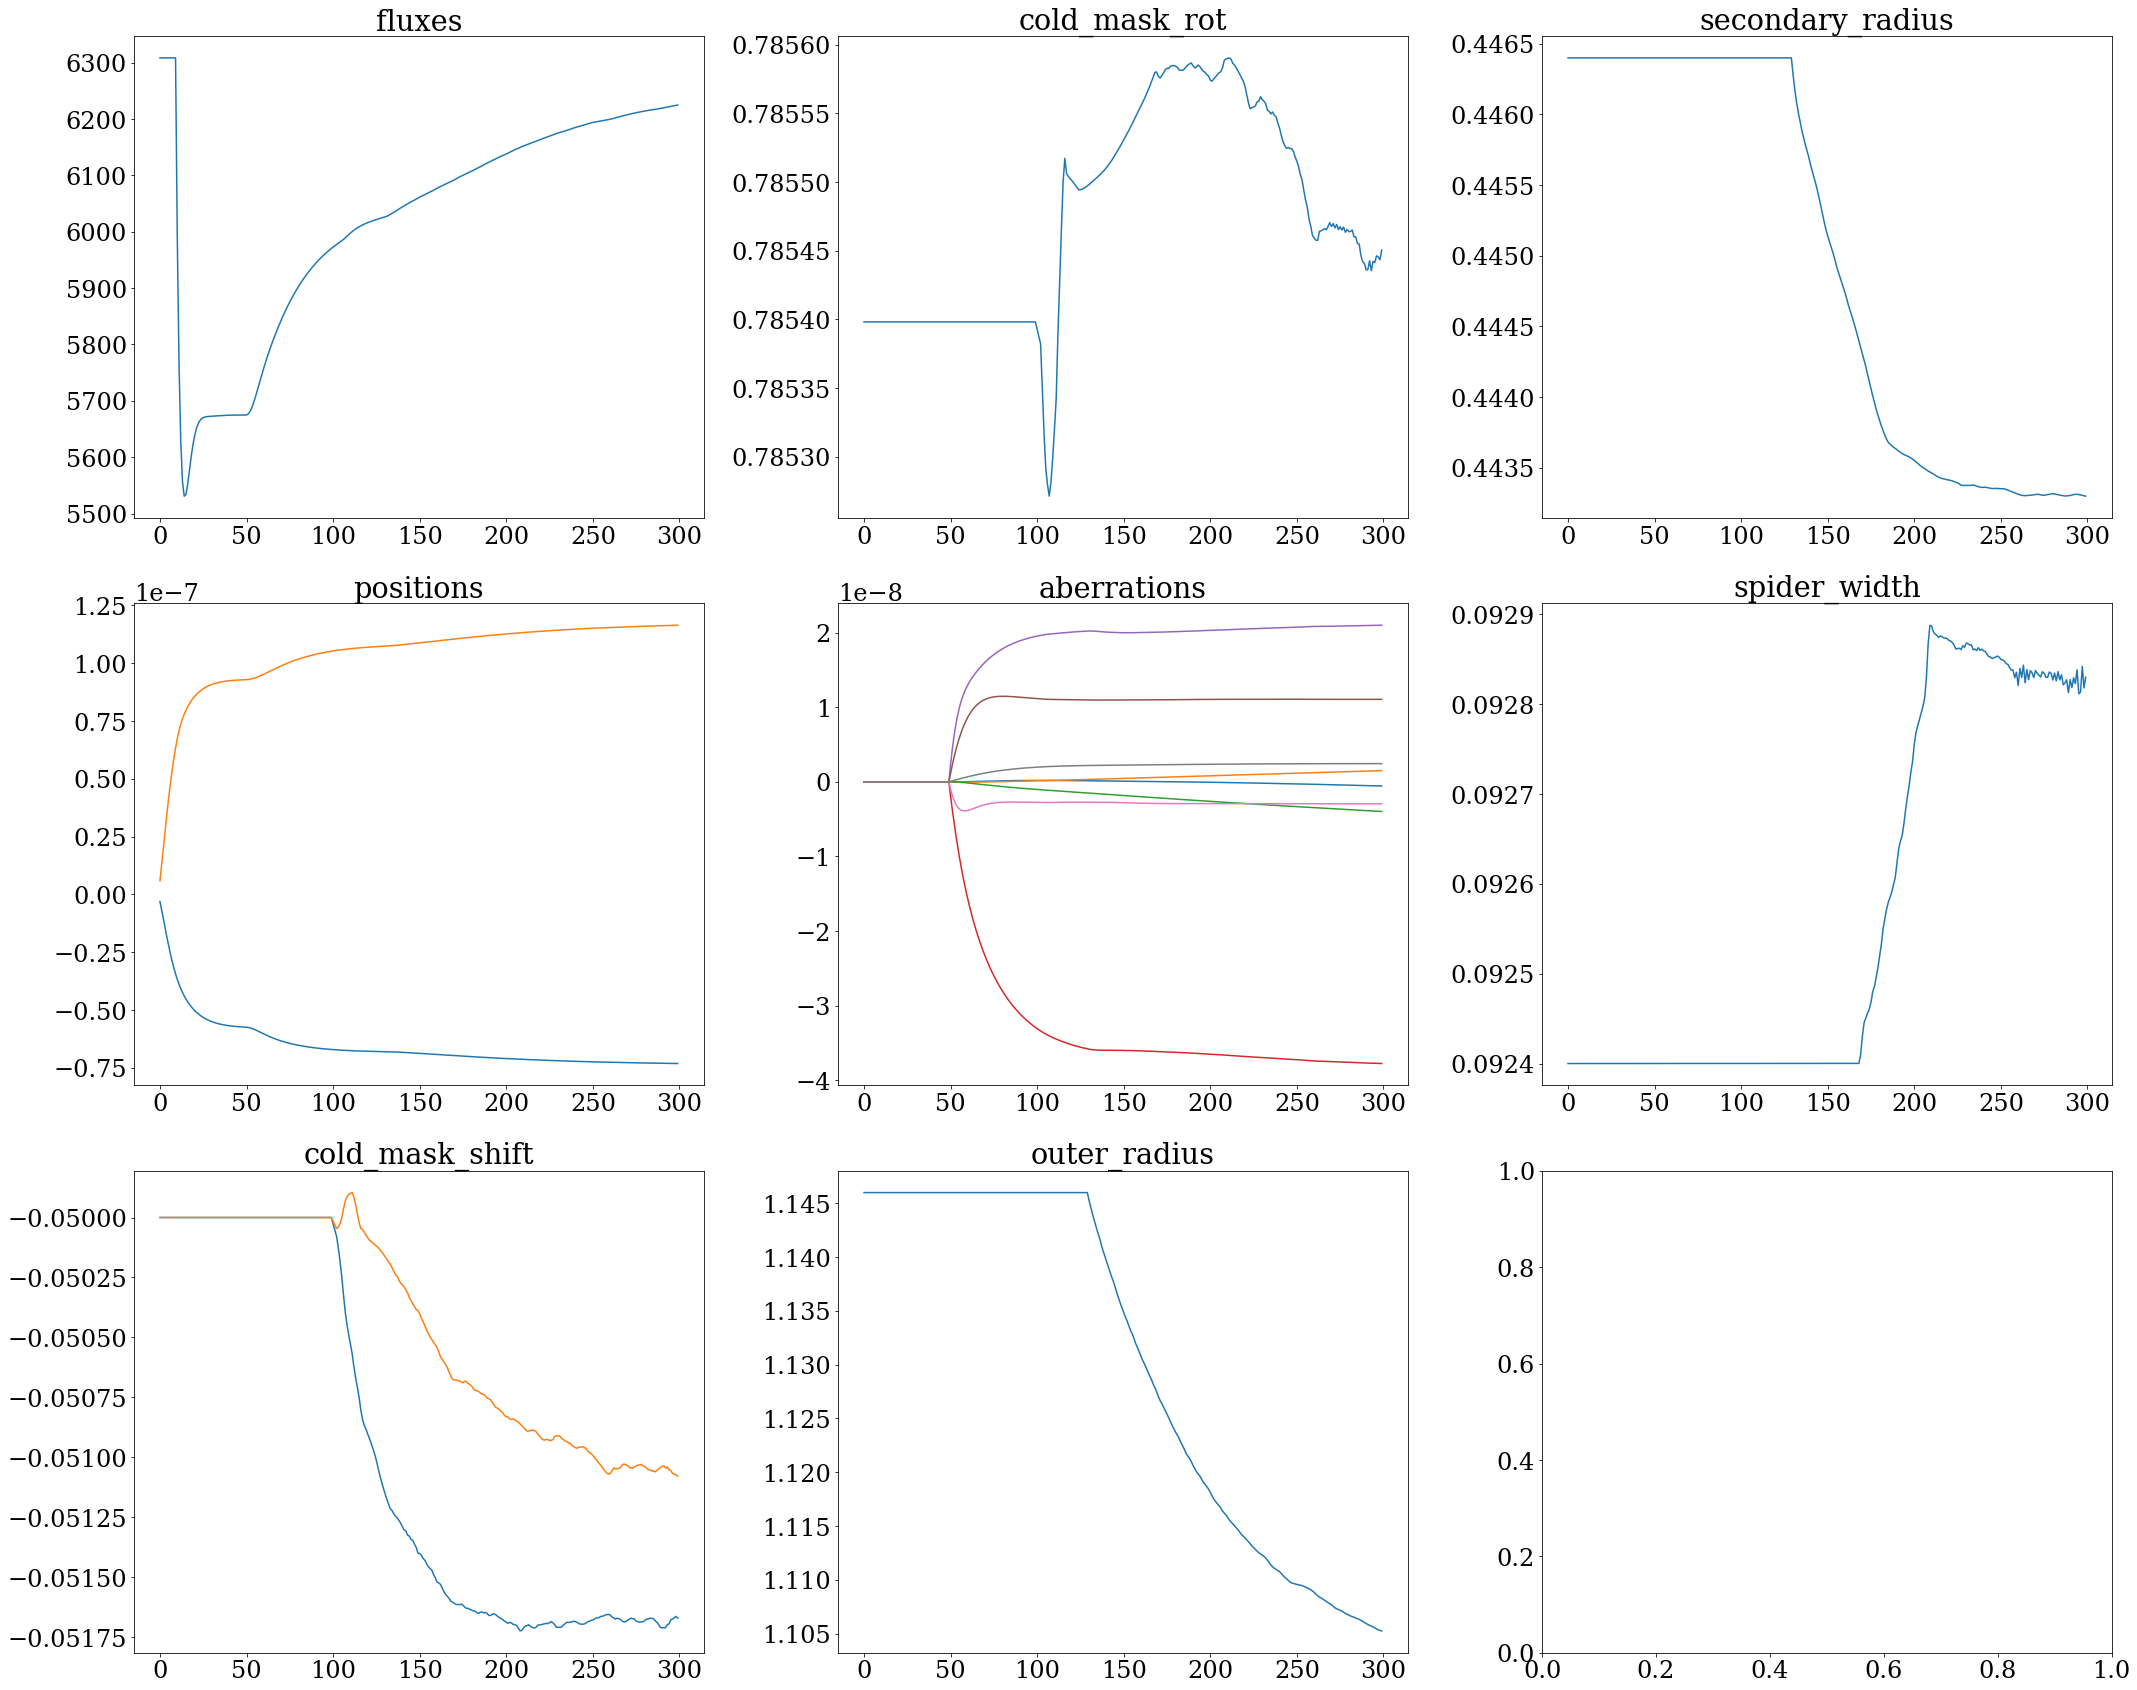

In [16]:
xw = 3
yw = int(np.ceil(len(groups_s)/xw))

print(len(groups_s))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups_s):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", "cold_mask_shift", "cold_mask_rot"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models_s]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models_s])
    
fig.tight_layout()

11


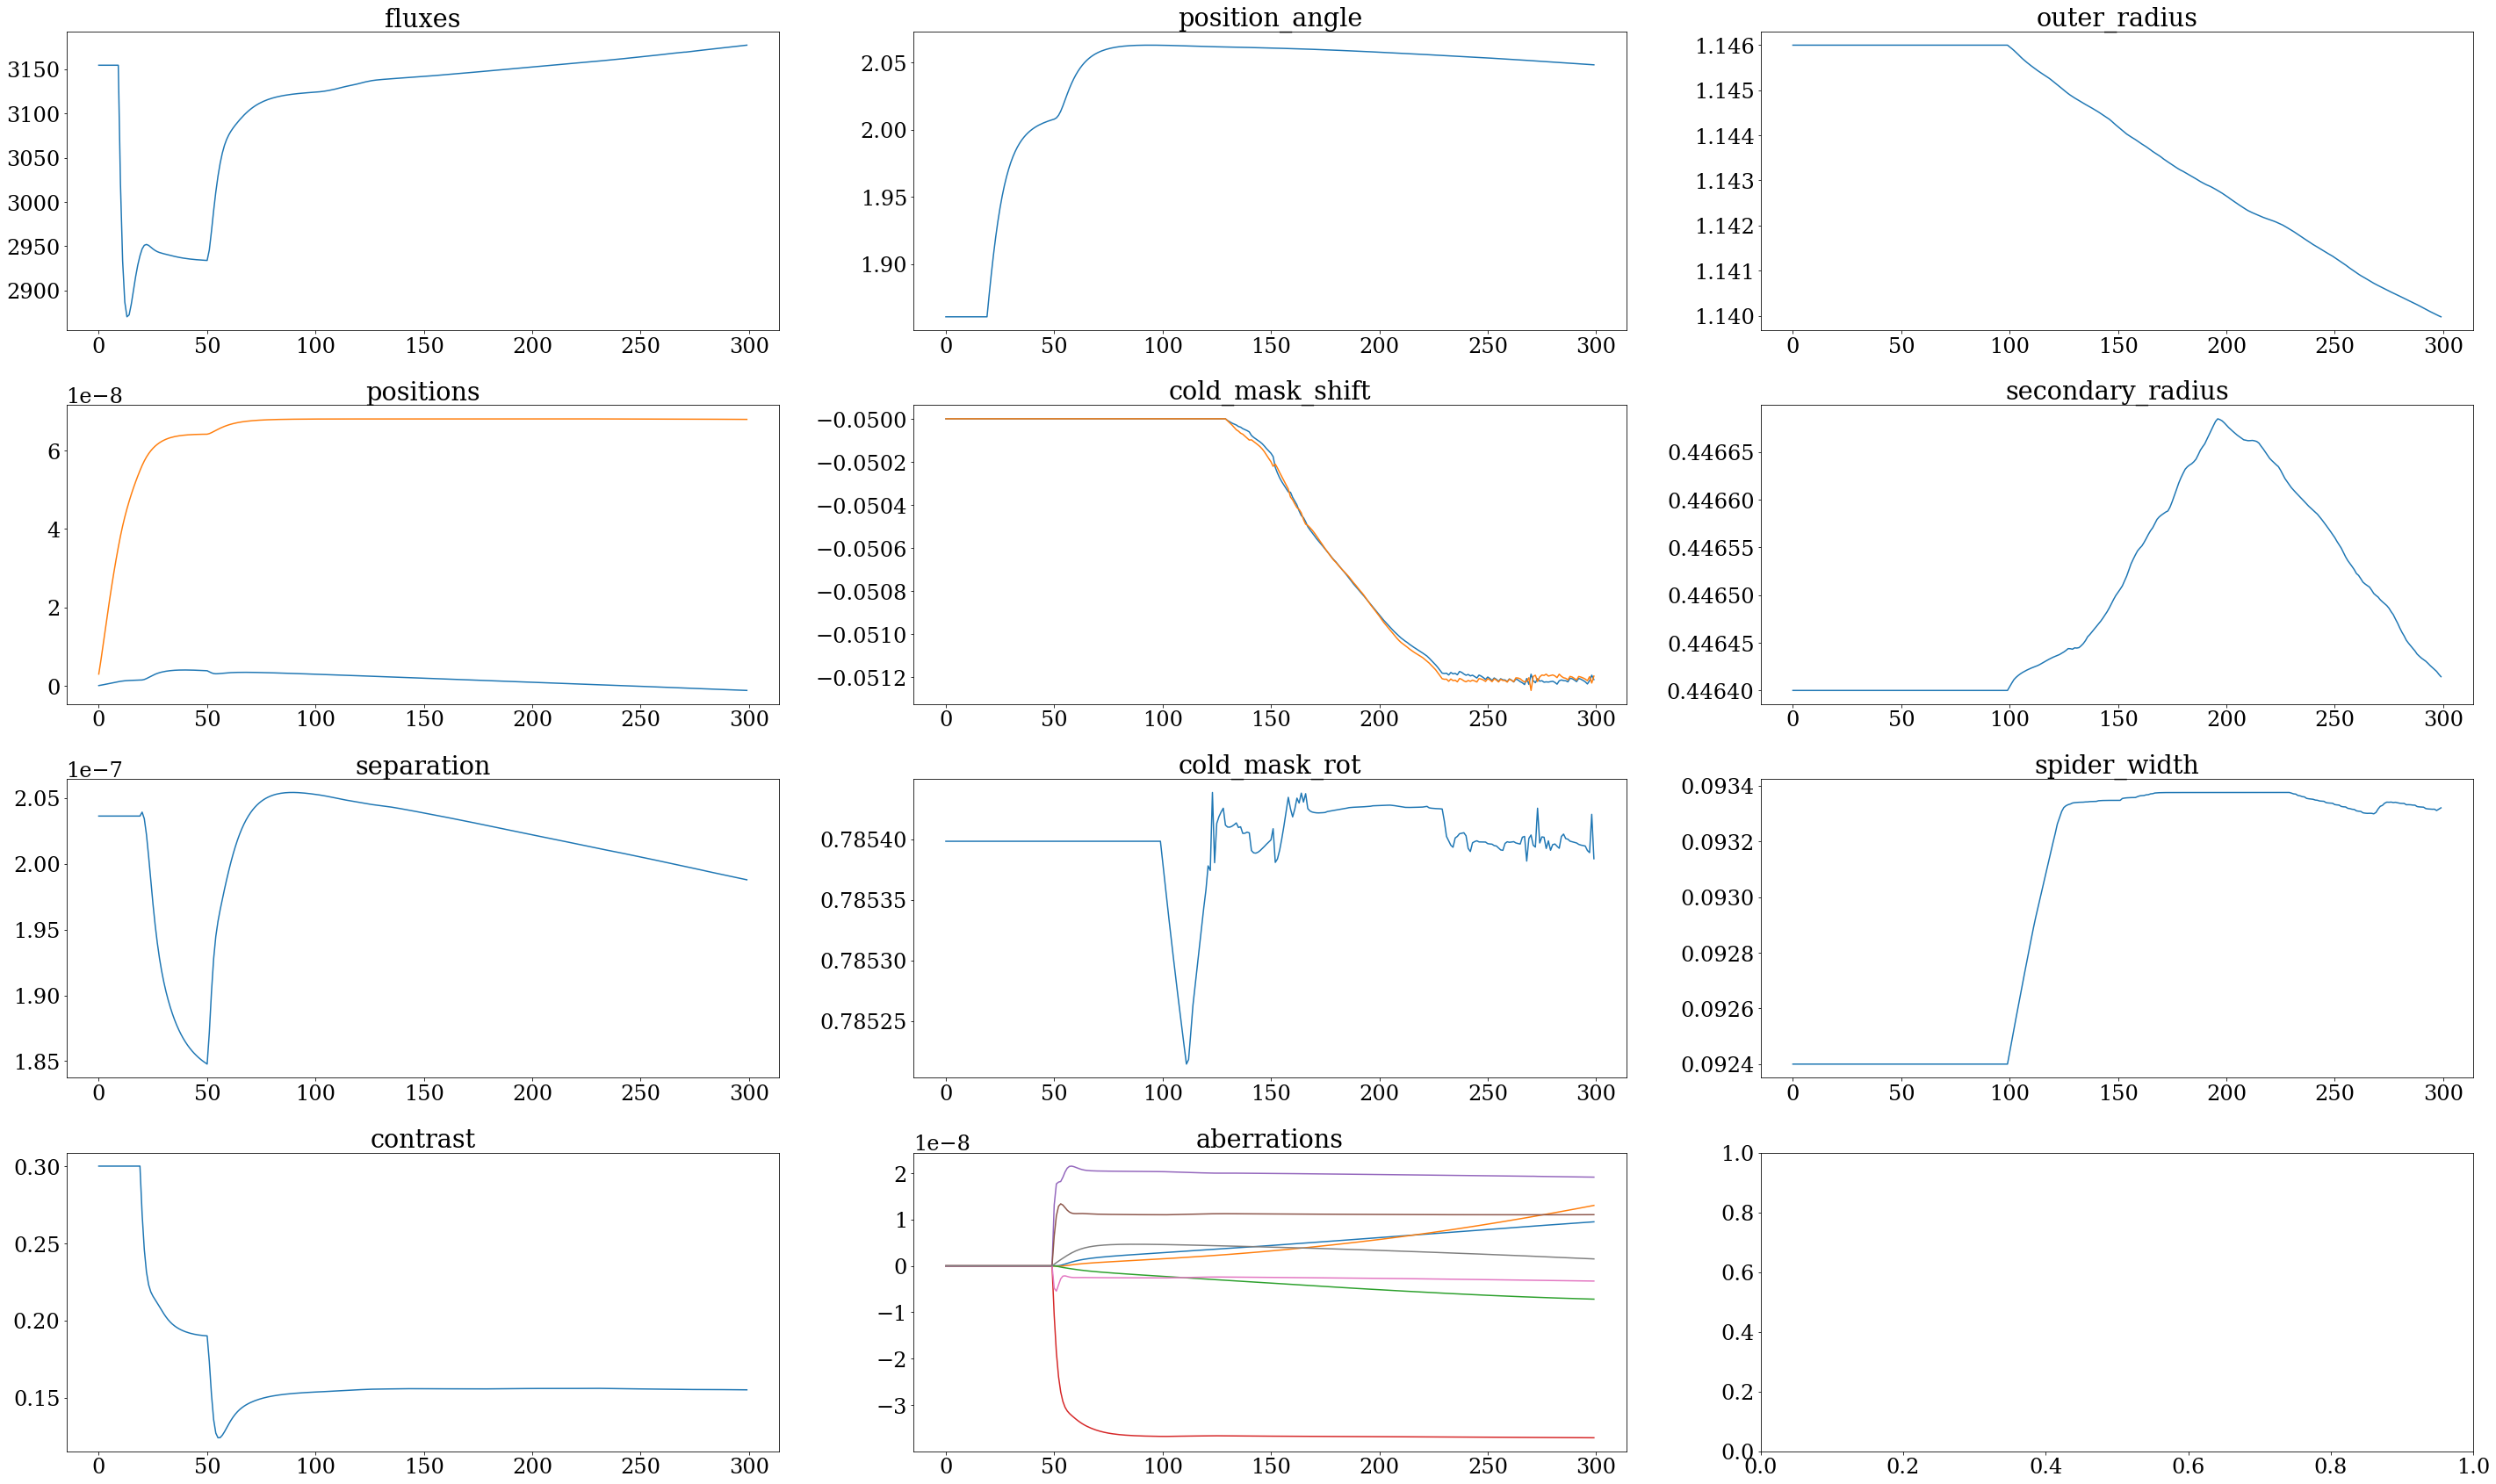

In [17]:
xw = 4
yw = int(np.ceil(len(groups_b)/xw))

print(len(groups_b))

fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups_b):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", "cold_mask_shift", "cold_mask_rot"]:
        #print(np.asarray(list(models_b[0].get(param).values())))
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models_b]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models_b])
    
fig.tight_layout()

Evidence

In [18]:
print(loss_fn_b(params_b, exposures_b))

(Array(635225.28270249, dtype=float64), ModelParams(
  params={
    'aberrations':
    {'N43CA5020': f64[8]},
    'cold_mask_rot':
    {'N43CA5020': f64[]},
    'cold_mask_shift':
    {'N43CA5020': f64[2]},
    'contrast':
    {'N43CA5020': f64[]},
    'fluxes':
    {'N43CA5020': f64[]},
    'outer_radius':
    f64[],
    'position_angle':
    f64[],
    'positions':
    {'N43CA5020': f64[2]},
    'secondary_radius':
    f64[],
    'separation':
    f64[],
    'spider_width':
    f64[]
  }
))


In [19]:
def loss_fn_b_params(params,exposures):
    model = params.inject(binary_model)
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))

def loss_fn_s_params(params,exposures):
    model = params.inject(point_model)
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))


loss_fn_b_params(params_b, exposures_b)

Array(635225.28270249, dtype=float64)

In [20]:
binary_model

NICMOSModel(
  params={
    'aberrations':
    {'N43CA5020': f64[8]},
    'cold_mask_rot':
    {'N43CA5020': f64[]},
    'cold_mask_shift':
    {'N43CA5020': f64[2]},
    'contrast':
    {'N43CA5020': f64[]},
    'fluxes':
    {'N43CA5020': f64[]},
    'outer_radius':
    f64[],
    'position_angle':
    f64[],
    'positions':
    {'N43CA5020': f64[2]},
    'secondary_radius':
    f64[],
    'separation':
    f64[],
    'spider_width':
    f64[]
  },
  filters={'F095N': f64[28,2]},
  optics=NICMOSOptics(
    wf_npixels=512,
    diameter=f64[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=None,
        apertures={
          'cold_mask':
          NICMOSColdMask(
            normalise=True,
            transformation=CoordTransform(
              translation=f64[2],
              rotation=f64[],
              compression=None,
              shear=None
            ),
            apertures={
              'outer':
          

In [21]:
#hessian = jax.hessian(loss_fn_b_params)(params_b, exposures_b)

In [22]:
rc = True
fishers_s = calc_fishers(point_model, exposures_s, paths_s, recalculate=rc, save=False)

fishers_b = calc_fishers(binary_model, exposures_b, paths_b, recalculate=rc, save=False)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[6.46537672]]
[[4.45575989e+21 2.91349557e+19]
 [2.91349557e+19 5.44784950e+21]]
[[9.28308767e+08 5.42342997e+08]
 [5.42342997e+08 1.04965319e+09]]
[[7.50773407e+08]]
[[ 3.99492896e+20  4.44484275e+20 -2.46516589e+20  6.61830274e+20
   7.43409791e+20  1.97674453e+20  5.39609009e+19  3.20516472e+20]
 [ 4.44484275e+20 -2.63093348e+20 -6.57983992e+19  7.47802991e+20
   4.85692106e+20  6.83336820e+19  1.10568983e+20  2.03351282e+20]
 [-2.46516589e+20 -6.57983992e+19  2.33429748e+20 -2.82412840e+20
   1.86245197e+20 -3.19135794e+20 -1.78386553e+20 -1.27417559e+20]
 [ 6.61830274e+20  7.47802991e+20 -2.82412840e+20  5.46125547e+21
  -6.24668530e+20  2.31856262e+19  1.14221982e+20 -1.87519245e+20]
 [ 7.43409791e+20  4.85692106e+20  1.86245197e+20 -6.24668530e+20
   4.27914733e+21  2.04093336e+20 -4.59183357e+20  2.83162048e+19]
 [ 1.97674453e+20  6.83336820e+19 -3.19135794e+20  2.31856262e+19
   2.04093336e+20  3.54583354e+21 -2.50267616e+20  9.56983911e+19]
 [ 5.39609009e+19  1.10568983e+20 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[[24.88202428]]
[[4.31491974e+21 1.51199452e+20]
 [1.51199452e+20 5.37767103e+21]]
[[9.99503369e+20]]
[[1.02348149e+08]]
[[33675526.85543563]]


2024-08-11 16:38:57.058132: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %transpose.15 = c128[28,2,512,512]{2,3,0,1} transpose(c128[2,28,512,512]{3,2,1,0} %constant.143), dimensions={1,0,3,2}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-08-11 16:38:58.041472: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.987471s
Constant folding an instruction is taking > 1s:

  %transpose.15 = c128[28,2,512,512]{2,3,0,1} transpose(c128[2,28,512,512]{3,2,1,0} %constant.143), dimensions={1,0,3,2}

This isn't necessarily a bug; constant-folding is inherently a

[[ 1.03748515e+09 -1.01126864e+09]
 [-1.01126864e+09  1.59013246e+09]]


KeyboardInterrupt: 

In [ ]:
fishers_b['N43CA5020']

{'fluxes': Array([[24.88202428]], dtype=float64),
 'positions': Array([[4.31491974e+21, 1.51199452e+20],
        [1.51199452e+20, 5.37767103e+21]], dtype=float64),
 'separation': Array([[9.99503369e+20]], dtype=float64),
 'contrast': Array([[1.02348149e+08]], dtype=float64),
 'position_angle': Array([[33675526.85543563]], dtype=float64),
 'cold_mask_shift': Array([[ 1.03748515e+09, -1.01126864e+09],
        [-1.01126864e+09,  1.59013246e+09]], dtype=float64),
 'cold_mask_rot': Array([[1.65155523e+09]], dtype=float64),
 'aberrations': Array([[ 5.65941070e+20,  4.40625381e+20, -2.84605341e+20,
          1.38404945e+20,  5.82538916e+20,  3.46469682e+20,
         -3.58088311e+18,  3.70623394e+20],
        [ 4.40625381e+20,  2.66616877e+20, -3.90932989e+20,
          8.92870157e+19,  5.01352533e+20, -4.98762124e+18,
          1.51656828e+20,  3.03522309e+20],
        [-2.84605341e+20, -3.90932989e+20,  7.82817837e+20,
          4.09894043e+20,  2.20892937e+19, -3.57053358e+20,
         -4.6

In [ ]:
#hessian.params["contrast"]["N43CA5020"].params["contrast"]["N43CA5020"]

In [ ]:
logdet_s = sum([np.linalg.slogdet(x).logabsdet for x in list(fishers_s['N43CA5020'].values())[:]])
logdet_b = sum([np.linalg.slogdet(x).logabsdet for x in list(fishers_b['N43CA5020'].values())[:]])
print(logdet_s)
print(logdet_b)

619.2061687532115
696.1447848391778


In [ ]:
params_b

ModelParams(
  params={
    'aberrations':
    {'N43CA5020': f64[8]},
    'cold_mask_rot':
    {'N43CA5020': f64[]},
    'cold_mask_shift':
    {'N43CA5020': f64[2]},
    'contrast':
    {'N43CA5020': f64[]},
    'fluxes':
    {'N43CA5020': f64[]},
    'outer_radius':
    f64[],
    'position_angle':
    f64[],
    'positions':
    {'N43CA5020': f64[2]},
    'secondary_radius':
    f64[],
    'separation':
    f64[],
    'spider_width':
    f64[]
  }
)

In [ ]:
D_s = 17#sum([len(x) for x in params_s.params['N43CA5020'].values()])
print(D_s)
D_b = 20#sum([len(x) for x in params_b.params['N43CA5020'].values()])


17


In [ ]:
D_s/2 * np.log(2*np.pi) + 1/2 * logdet_s - loss_fn_s_params(params_s, exposures_s)

Array(-981678.85926302, dtype=float64)

In [ ]:
D_b/2 * np.log(2*np.pi) + 1/2 * logdet_b - loss_fn_b_params(params_b, exposures_b)

Array(-634858.83153941, dtype=float64)

In [ ]:
print(list(fishers_s['N43CA5020'].keys()))

['fluxes', 'positions', 'cold_mask_shift', 'cold_mask_rot', 'aberrations', 'outer_radius', 'secondary_radius', 'spider_width']


In [ ]:
np.linalg.slogdet()

TypeError: slogdet() missing 1 required positional argument: 'a'

In [ ]:
def log_det(X):
    mag = np.mean(np.abs(X))
    ld = np.log10(np.abs(np.linalg.det((X)/mag)))
    #print(ld,X/mag)
    return ld + np.log10(mag*X.shape[0])

In [ ]:
vals = np.asarray([log_det(x) for x in list(fishers_s['N43CA5020'].values())])[:-1]
np.sum(vals)+len(vals)/2 * np.log10(np.sqrt(2*np.pi)) + loss_fn_b_params(params_s, exposures_s)/(wid**2)

Array(348.76166, dtype=float32)

In [ ]:
vals = np.asarray([np.linalg.det(np.abs(x)/1e17) for x in list(fishers_s['N43CA5020'].values())])[:-1]
print(vals,len(vals))
le = np.sum(np.log10(np.abs(vals)))
print(le)

[ 6.6596285e-17  2.5060178e+09  5.7386980e-16  3.9659685e-08
 -2.8137976e+31  1.9567434e-08  5.4487179e-09] 7
-13.943282


In [ ]:
#fishers_s
#[[numpy.linalg.det(u.astype(np.float64)) for u in v.values()] if type(v)==dict else numpy.linalg.det(v) for v in fishers_s.values()]